## Check the Gravitational Potential with 1 particle

In [731]:
# Python
from datetime import datetime

# MPL
import matplotlib        as mpl
import matplotlib.pyplot as plt

# NumPy
import numpy as np
from numpy import cos, exp, log, pi, sin, sqrt
from numpy.random import default_rng

# Scipy
import scipy.linalg as linalg
from scipy.fft import*

In [732]:
# input initial conditions:
L = 1 # m
Rs = L/4 # m
Np = 1 # # of particles
m_p = 1 # kg
part = np.zeros((Np, 9)) # position * 3 (0-2); acceleration * 3 (3-5); velocity * 3 (6-8)
pos = np.zeros((Np, 3)) # position
rng = np.random.default_rng(seed=42) # seed

# Generate random numbers for spherical coordinates:
r = Rs * np.cbrt(rng.uniform(0, 1, Np))
phi = rng.uniform(0, 2 * np.pi, Np)
theta = np.arccos(1 - 2 * rng.uniform(0, 1, Np))

# Convert the spherical coordinates to Cartesian:
x = r * np.sin(theta) * np.cos(phi) + L/2
y = r * np.sin(theta) * np.sin(phi) + L/2 
z = r * np.cos(theta) + L/2

# Add position coordinates: 
pos[:, 0], pos[:, 1], pos[:, 2] = x, y, z

# Print something:
print('The initial conditions is setted.')
print(pos)

The initial conditions is setted.
[[0.35169609 0.55992999 0.33537977]]


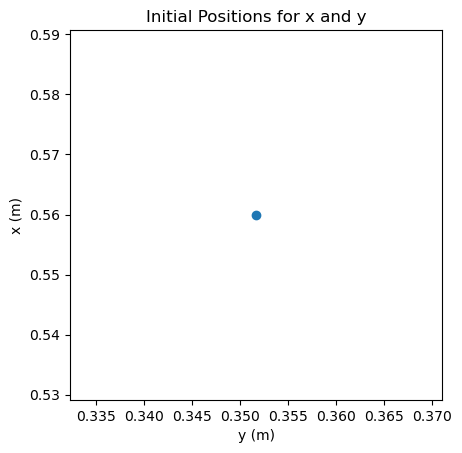

In [733]:
# Plot the inital positions:
plt.figure(figsize=(4.8,4.8))
plt.plot(x, y, 'o')
plt.title('Initial Positions for x and y')
plt.xlabel('y (m)')
plt.ylabel('x (m)')
plt.show()

In [734]:
# Input data:
Nc = 32 # cells per side length
l = L / Nc # length for each cubical cell

def density_field(pos):
    density = np.zeros((Nc, Nc, Nc))

    for part in range(Np):
        x, y, z = pos[part,0], pos[part,1], pos[part,2]

        # grids that contain particles:
        i, j, k = int(np.floor(x / l)), int(np.floor(y / l)), int(np.floor(z / l))

        # Number of overlaps:
        dx, dy, dz = (x / l) - i, (y / l) - j, (z / l) - k

        # Weight:
        weights = [(1 - dx) * (1 - dy) * (1 - dz), dx * (1 - dy) * (1 - dz), (1 - dx) * dy * (1 - dz), dx * dy * (1 - dz), 
            (1 - dx) * (1 - dy) * dz, dx * (1 - dy) * dz, (1 - dx) * dy * dz, dx * dy * dz] # 8 in total
        
        # Update density grid:
        for di, dj, dk, w in zip(
            [0, 1, 0, 1, 0, 1, 0, 1],  # x direction
            [0, 0, 1, 1, 0, 0, 1, 1],  # y direction
            [0, 0, 0, 0, 1, 1, 1, 1],  # z direction
            weights
        ):
            density[(i + di) % Nc, (j + dj) % Nc, (k + dk) % Nc] += m_p * w

    # Normalization:
    density /= l**3

    return density

# check 
density = density_field(pos)
mass = density.sum() * l**3
if int(mass - Np * m_p) == 0:
    print("The density is correct.")
else:
    print("Wrong!")

The density is correct.


In [735]:
# Input data:
G = 6.67430e-11  # m^3 kg^-1 s^-2
Nk = Nc

def potential_field(density):
    phi_k = np.zeros((Nk, Nk, Nk//2 + 1), dtype = complex)

    # FFT for the density field:
    rho_k = np.fft.rfftn(density)
    
    for i in range(Nk):
        for j in range(Nk):
            for k in range(Nk//2 + 1):
                if i <= Nk/2:
                    kx = 2 * np.pi / Nc * i
                else:
                    kx = 2 * np.pi / Nc * (i - Nk)                
                if j <= Nk/2:
                    ky = 2 * np.pi / Nc * j
                else:
                    ky = 2 * np.pi / Nc * (j - Nk)
                if k <= Nk/2:             
                    kz = 2 * np.pi / Nc * k
                else: 
                     kz = 2 * np.pi / Nc * (k - Nk)

                D = ((2 * np.sin(kx/2))**2 + (2 * np.sin(ky/2))**2 + (2 * np.sin(kz/2))**2 + 1e-9)
                factor = L / Nc # factor due to the normalization of FFt
                omega_k = - (4 * np.pi * G) / D 

                phi_k[i, j, k] = omega_k * rho_k[i,j,k] * factor

    # Inverse FFT for the potential field:
    phi= np.fft.irfftn(phi_k) 

    return phi

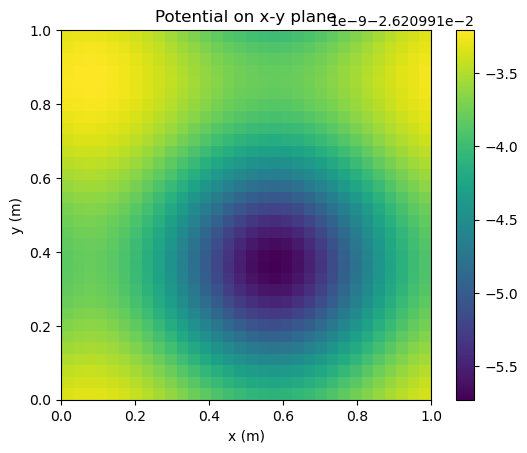

In [736]:
rho = density_field(pos)
phi = potential_field(rho)[:,:,0]

plt.imshow(phi, origin='lower', extent=[0.0,L,0.0,L])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Potential on x-y plane')
plt.colorbar()
plt.show()

## Debugging with the force

In [ ]:
def cal_force(phi):
    # Initialize for the force matrix:
    Fx = np.zeros((Nc, Nc, Nc))
    Fy = np.zeros((Nc, Nc, Nc))
    Fz = np.zeros((Nc, Nc, Nc))
    F = np.zeros((Nc, Nc, Nc, 3))

    # Computation for the force:
    # Fx: 
    for i in range(Nc):
        if i == 0: 
            Fx[i, :, :] = -(phi[i+1, :, :] - phi[i, :, :]) / l
        if i == Nc - 1:
            Fx[i, :, :] = -(phi[i, :, :] - phi[i-1, :, :]) / l
        else:
            Fx[i, :, :] = -(phi[i+1, :, :] - phi[i-1, :, :]) / (2*l)
    # Fy:
    for j in range(Nc):
        if j == 0: 
            Fy[:, j, :] = -(phi[:, j+1, :] - phi[:, j, :]) / l
        if j == Nc - 1:
            Fy[:, j, :] = -(phi[:, j, :] - phi[:, j-1, :]) / l
        else:
            Fy[:, j, :] = -(phi[:, j+1, :] - phi[:, j-1, :]) / (2*l)

    # Fz:
    for k in range(Nc):
        if k == 0: 
            Fz[:, :, k] = -(phi[:, :, k+1] - phi[:, :, k]) / l
        if k == Nc - 1:
            Fz[:, :, k] = -(phi[:, :, k] - phi[:, :, k-1]) / l
        else:
            Fz[:, :, k] = -(phi[:, :, k+1] - phi[:, :, k-1]) / (2*l)
    
    F[:,:,:,0] = Fx
    F[:,:,:,1] = Fy
    F[:,:,:,2] = Fz

    return F 

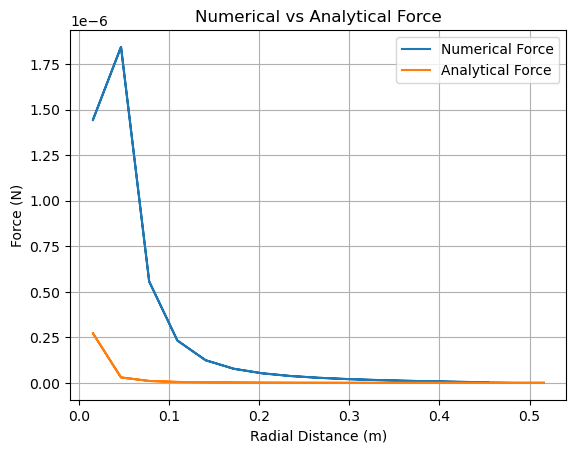

In [739]:
# Parameters
L = 1.0  # m
Nc = 32  
Np = 1  # Single particle
m_p = 1.0  # kg
G = 6.67430e-11  # Gravitational constant
l = L / Nc  

# Set position:
pos = np.array([[L / 2 + l / 2, L / 2, L / 2]]) 
density = density_field(pos)

# Potential field and force:
phi = potential_field(density)
F = cal_force(phi)
f_numerical = np.sqrt(F[:,:,:,0]**2 + F[:,:,:,1]**2 + F[:,:,:,2]**2)

# Compute analytical force
grid_x, grid_y, grid_z = np.meshgrid(np.linspace(0, L, Nc, endpoint=False),
                                     np.linspace(0, L, Nc, endpoint=False),
                                     np.linspace(0, L, Nc, endpoint=False),
                                     indexing='ij') 

particle_pos = pos[0]
r = np.sqrt((grid_x - particle_pos[0])**2 +
            (grid_y - particle_pos[1])**2 +
            (grid_z - particle_pos[2])**2)
r[r == 0] = 1e-9  # Avoid division by zero

f_analytical = G * m_p / r**2

# Data for plotting: (choose for only one direction)
r_line = r[:, Nc//2, Nc//2]
f_analytical = f_analytical[:, Nc//2, Nc//2]
f_numerical = f_numerical[:, Nc//2, Nc//2]

# Plotting
plt.plot(r_line, f_numerical, label="Numerical Force")
plt.plot(r_line, f_analytical, label="Analytical Force")
plt.xlabel("Radial Distance (m)")
plt.ylabel("Force (N)")
plt.title("Numerical vs Analytical Force")
plt.legend()
plt.grid()
plt.show()